In [1]:
import numpy as np
import pkg_resources
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
from flygym.envs.nmf_mujoco import NeuroMechFlyMuJoCo, MuJoCoParameters
from tqdm import trange
from flygym.util.config import all_leg_dofs
from flygym.state import stretched_pose

from flygym.arena.mujoco_arena import MixedTerrain, BlocksTerrain, GappedTerrain, FlatTerrain

from flygym.util.CPG_helpers import (
    advancement_transfer,
    phase_oscillator,
    initialize_solver,
    phase_biases_tripod_idealized,
    plot_phase_amp_output,
    sine_output,
)

from tqdm import trange

In [2]:
arena = MixedTerrain()

# Initialize simulation
run_time = 1


sim_params = MuJoCoParameters(timestep=1e-4, render_mode="saved", render_playspeed=0.1, render_camera="Animat/camera_left",
                               enable_adhesion=True, draw_adhesion=True)
nmf = NeuroMechFlyMuJoCo(
    sim_params=sim_params,
    init_pose=stretched_pose,
    actuated_joints=all_leg_dofs,
    arena = arena,
    spawn_pos = [3.0, 0, 0.5]
)
num_steps_base = int(run_time / nmf.timestep)

In [3]:
# Load recorded data
data_path = Path(pkg_resources.resource_filename('flygym', 'data'))
with open(data_path / 'behavior' / 'single_steps.pkl', 'rb') as f:
    data = pickle.load(f)

In [4]:
# Interpolate 5x
step_duration = len(data['joint_LFCoxa'])
interp_step_duration = int(step_duration * data['meta']['timestep'] / nmf.timestep)
data_block = np.zeros((len(nmf.actuated_joints), interp_step_duration))
measure_t = np.arange(step_duration) * data['meta']['timestep']
interp_t = np.arange(interp_step_duration) * nmf.timestep
for i, joint in enumerate(nmf.actuated_joints):
    data_block[i, :] = np.interp(interp_t, measure_t, data[joint])

In [5]:
LEGS = ["RF", "RM", "RH", "LF", "LM", "LH"]

leg_ids = np.arange(len(LEGS)).astype(int)
leg_corresp_id = dict(zip(LEGS, leg_ids))
n_joints = len(nmf.actuated_joints)
joint_ids = np.arange(n_joints).astype(int)
match_leg_to_joints = np.array(
    [
        i
        for joint in nmf.actuated_joints
        for i, leg in enumerate(LEGS)
        if leg in joint
    ]
)

In [6]:
########### CONSTANTS ############
CONTROLLER_SEED = 42
N_STABILIZATION_STEPS = 2000
N_OSCILLATORS = len(LEGS)

COUPLING_STRENGTH = 10.0
AMP_RATES = 20.0
TARGET_AMPLITUDE = 1.0

frequencies = np.ones(N_OSCILLATORS) * 10

# For now each oscillator have the same amplitude
target_amplitudes = np.ones(N_OSCILLATORS) * TARGET_AMPLITUDE
rates = np.ones(N_OSCILLATORS) * AMP_RATES

phase_biases = phase_biases_tripod_idealized * 2 * np.pi
coupling_weights = (np.abs(phase_biases) > 0).astype(float) * COUPLING_STRENGTH



In [7]:
num_steps = N_STABILIZATION_STEPS + num_steps_base

# Initilize the simulation
np.random.seed(CONTROLLER_SEED)
start_ampl = np.ones(6) * 0.2

nmf.reset()

solver = initialize_solver(
    phase_oscillator,
    "dopri5",
    nmf.curr_time,
    N_OSCILLATORS,
    frequencies,
    coupling_weights,
    phase_biases,
    start_ampl,
    rates,
    int_params={"atol": 1e-6, "rtol": 1e-6, "max_step": 100000},
)
all_adhesions = []

joint_angles = np.zeros((num_steps, len(nmf.actuated_joints)))
adhesion_signal = np.zeros(6)
# Initalize storage
obs_list = []
phases = np.zeros((num_steps, N_OSCILLATORS))
amplitudes = np.zeros((num_steps, N_OSCILLATORS))

all_indices = []

for i in trange(num_steps):
    res = solver.integrate(nmf.curr_time)
    phase = res[:N_OSCILLATORS]
    amp = res[N_OSCILLATORS : 2 * N_OSCILLATORS]

    phases[i, :] = phase
    amplitudes[i, :] = amp    

    if i == N_STABILIZATION_STEPS:
        # Now set the amplitude to their real values
        solver.set_f_params(
            N_OSCILLATORS,
            frequencies,
            coupling_weights,
            phase_biases,
            target_amplitudes,
            rates,
        )
    if i > N_STABILIZATION_STEPS:
        indices = advancement_transfer(
            phase, interp_step_duration, match_leg_to_joints
        )
        all_indices.append(indices)

        # scale amplitude by interpolating between the resting values and i timestep value
        input_joint_angles = (
            data_block[joint_ids, 0]
            + (data_block[joint_ids, indices] - data_block[joint_ids, 0])
            * amp[match_leg_to_joints]
        )
    else:
        input_joint_angles = data_block[joint_ids, 0]

    joint_angles[i, :] = input_joint_angles
    adhesion_signal = nmf.get_adhesion_vector()
    all_adhesions.append(adhesion_signal)

    action = {"joints": input_joint_angles, "adhesion": adhesion_signal}

    obs, _, _, _, _ = nmf.step(action)
    obs_list.append(obs)
    _ = nmf.render()

100%|██████████| 12000/12000 [00:37<00:00, 322.57it/s]


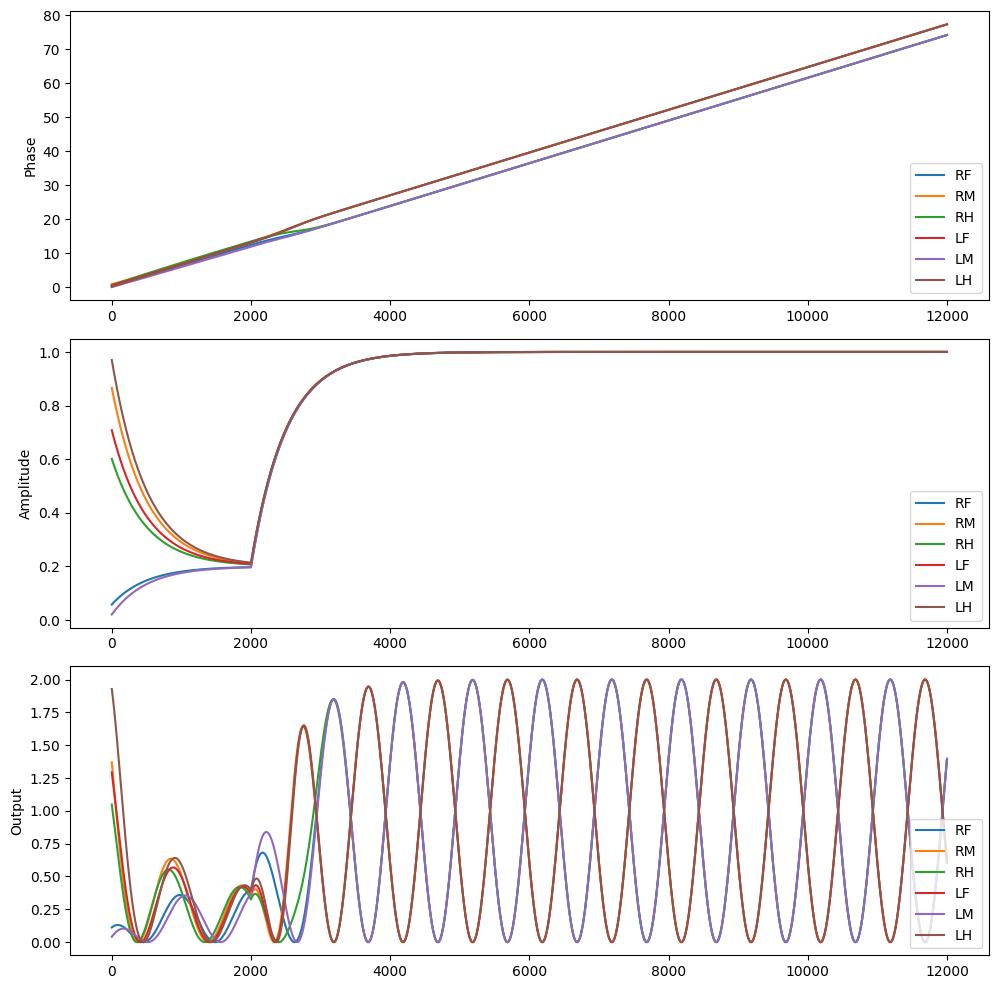

In [8]:
plot_phase_amp_output(phases, amplitudes, sine_output(phases, amplitudes), LEGS)

In [9]:
video_path = Path('kin_replay/video.mp4')
nmf.save_video(video_path)

from ipywidgets import Video
Video.from_file(video_path)

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free...')

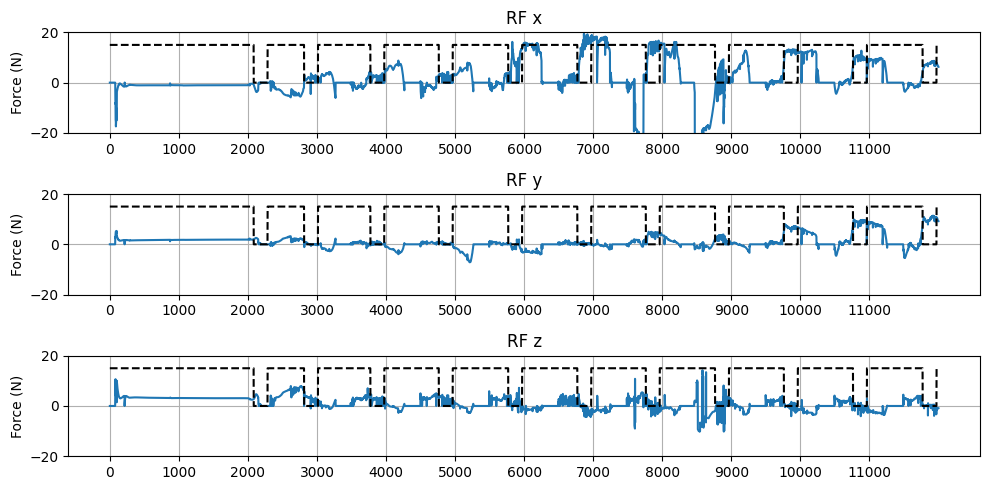

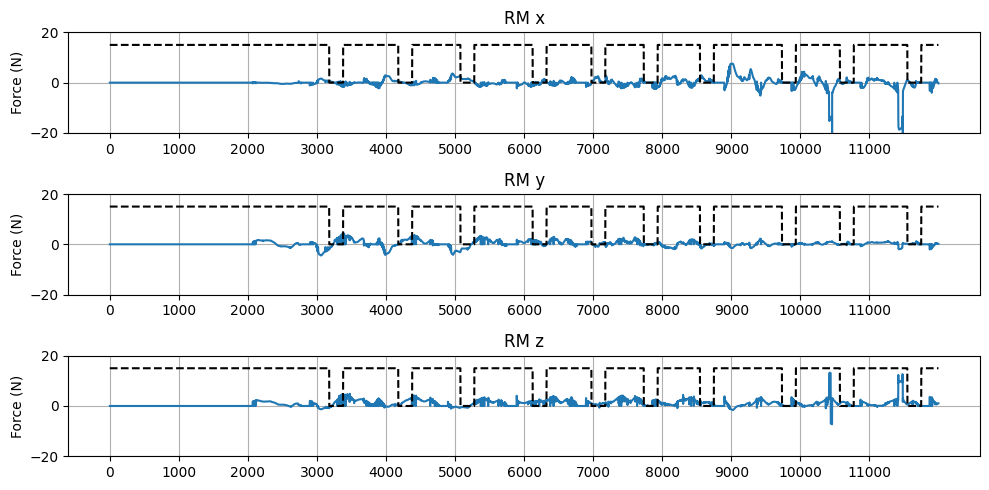

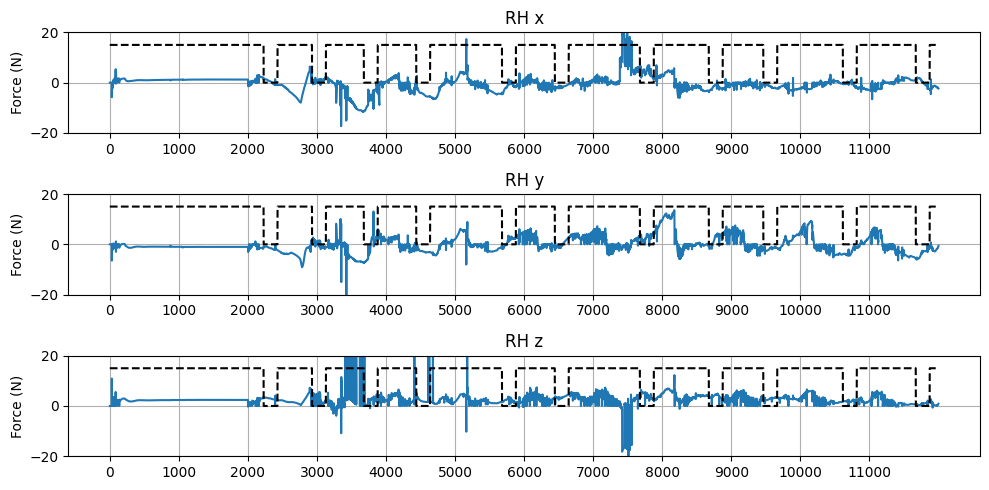

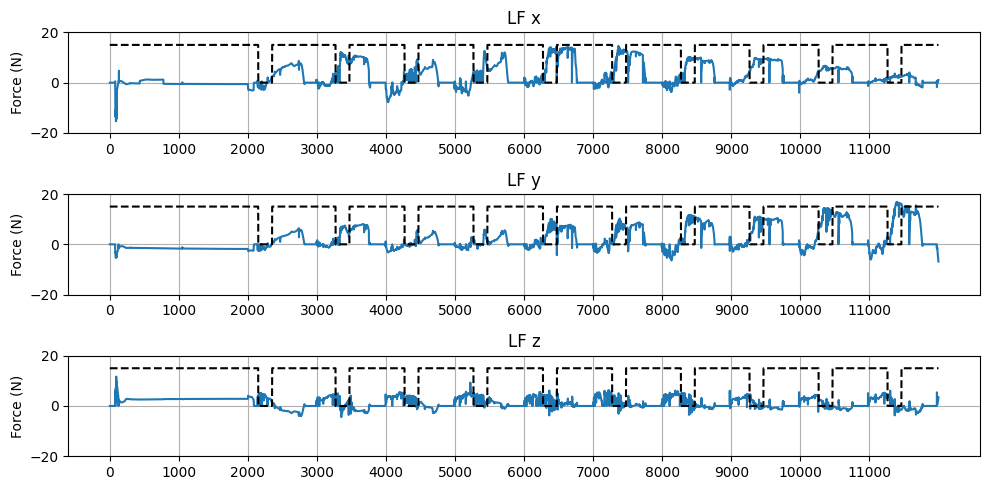

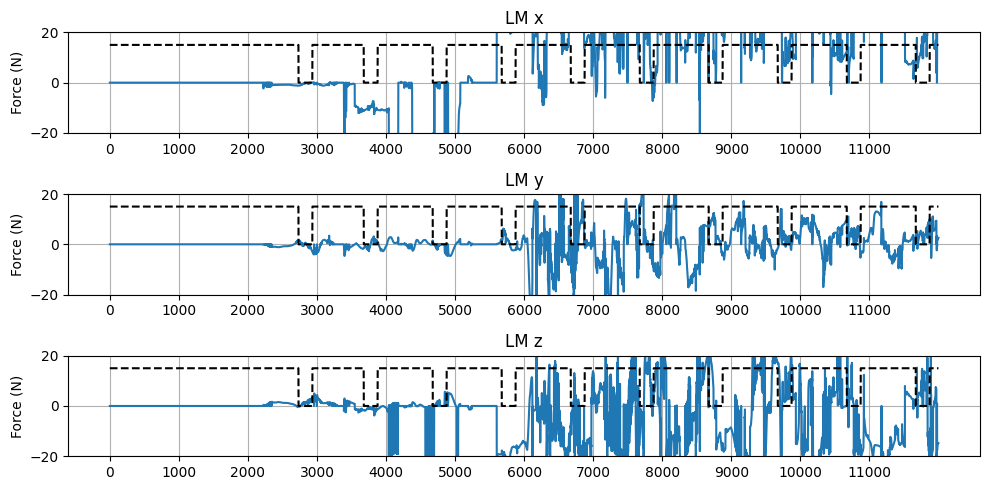

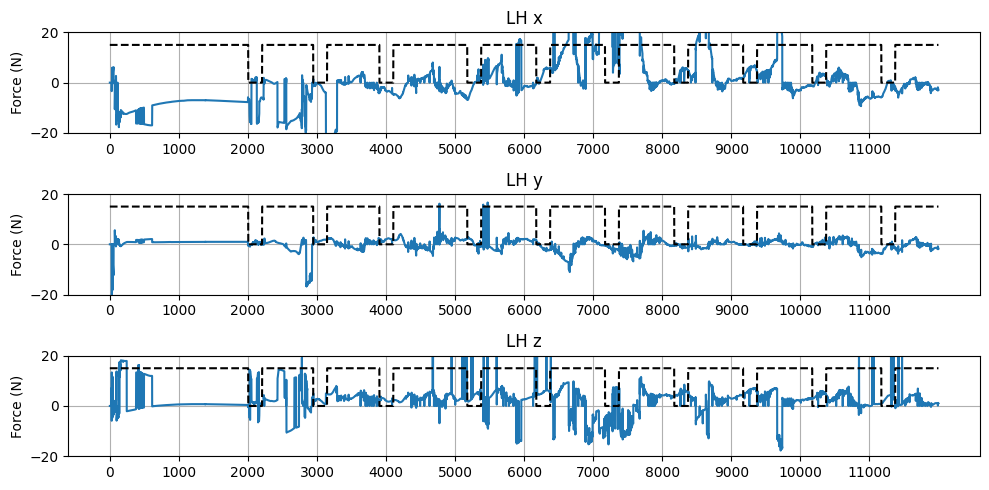

In [10]:
# plot all contact forces
all_adhesions = np.array(all_adhesions)
force_sensor_in_leg = [[i for i, cs in enumerate(nmf.contact_sensor_placements) if leg in cs] for leg in LEGS]
contact_forces = np.array([obs['contact_forces'] for obs in obs_list])

leg_contact_forces = np.array([contact_forces[:, :, force_sensor_in_leg[i]].sum(axis=-1) for i in range(N_OSCILLATORS)])

for i, leg in enumerate(LEGS):
    fig, axs = plt.subplots(3, 1, figsize=(10, 5), sharey=False)
    for j, coord in enumerate(["x", "y", "z"]):
        axs[j].plot(leg_contact_forces[i, :, j])
        axs[j].plot(all_adhesions[:, i]*15, "--", color = "black")
        axs[j].set_title(f"{leg} {coord}")
        axs[j].set_ylabel("Force (N)")
        """if j == 1:
            axs[j].legend(nmf.contact_sensor_placements[force_sensor_in_leg[i][0]:force_sensor_in_leg[i][-1]+1]+["adhesion"], loc = "lower left")"""
        axs[j].grid()
        # set ticks for every 1000 steps
        axs[j].set_xticks(np.arange(0, len(contact_forces), 1000))
        axs[j].set_ylim([-20, 20])
    plt.tight_layout()
    plt.show()


In [11]:
for c_id in range(nmf.physics.data.ncon):
    c = nmf.physics.data.contact[c_id]
    print(nmf.physics.model.id2name(c.geom1, 5),
          nmf.physics.model.id2name(c.geom2, 5),
          c.frame[:3])

groundblock_161 Animat/LFTarsus2_collision [-8.48303655e-15  1.35728585e-13  1.00000000e+00]
groundblock_161 Animat/LFTarsus4_collision [7.22112947e-14 0.00000000e+00 1.00000000e+00]
groundblock_161 Animat/LFTarsus5_collision [2.42505675e-13 0.00000000e+00 1.00000000e+00]
groundblock_161 Animat/LFTarsus5_collision [-9.99999834e-04  3.63689542e-14  9.99999500e-01]
groundblock_161 Animat/LFTarsus5_collision [ 2.73457631e-07 -9.99986161e-04  9.99999500e-01]
groundblock_160 Animat/LHTarsus4_collision [-1.40514244e-11 -1.66926957e-13  1.00000000e+00]
groundblock_160 Animat/LHTarsus5_collision [ 8.39033830e-14 -2.30323012e-14  1.00000000e+00]
groundblock_161 Animat/LMTibia_collision [-1.00000000e+00  1.09752642e-13  5.14008207e-13]
groundblock_160 Animat/LMTarsus1_collision [ 1.00000000e+00  0.00000000e+00 -9.84815382e-15]
groundblock_160 Animat/LMTarsus2_collision [ 1.00000000e+00  0.00000000e+00 -4.71694061e-14]
groundblock_160 Animat/LMTarsus3_collision [ 1.00000000e+00  2.69509933e-14 -2

In [12]:
nmf.physics.named.data.cfrc_ext

FieldIndexer(cfrc_ext):
  0                  world [ 0         0         0         0         0         0       ]
  1                Animat/ [ 0         0         0         0         0         0       ]
  2          Animat/Thorax [ 0         0         0         0         0         0       ]
  3            Animat/A1A2 [ 0         0         0         0         0         0       ]
  4              Animat/A3 [ 0         0         0         0         0         0       ]
  5              Animat/A4 [ 0         0         0         0         0         0       ]
  6              Animat/A5 [ 0         0         0         0         0         0       ]
  7              Animat/A6 [ 0         0         0         0         0         0       ]
  8       Animat/Head_roll [ 0         0         0         0         0         0       ]
  9        Animat/Head_yaw [ 0         0         0         0         0         0       ]
 10            Animat/Head [ 0         0         0         0         0         0      

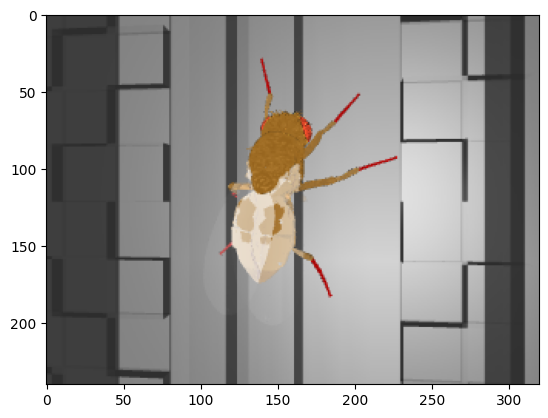

In [13]:
plt.imshow(nmf.physics.render(camera_id="Animat/camera_top"))

In [14]:
dir(nmf.physics.data)

['B_colind',
 'B_rowadr',
 'B_rownnz',
 'D_colind',
 'D_rowadr',
 'D_rownnz',
 '_HAS_DYNAMIC_ATTRIBUTES',
 '__class__',
 '__copy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_data',
 '_make_copy',
 '_model',
 'act',
 'act_dot',
 'actuator',
 'actuator_force',
 'actuator_length',
 'actuator_moment',
 'actuator_velocity',
 'body',
 'bvh_active',
 'cacc',
 'cam',
 'cam_xmat',
 'cam_xpos',
 'camera',
 'cdof',
 'cdof_dot',
 'cfrc_ext',
 'cfrc_int',
 'cinert',
 'contact',
 'contact_force',
 'copy',
 'crb',
 'ctrl',
 'cvel',
 'efc_AR',
 'efc_AR_colind',
 'efc_AR_rowadr',
 'efc_AR_rownnz',
 'efc_D',
 'efc_J',
 'efc_JT',
 'efc_JT_colind',
 'efc_JT_ro

In [29]:
nmf.physics.data.qfrc_constraint.shape

(93,)

In [15]:
np.average(nmf.physics.data.subtree_com, axis= 0, weights=nmf.physics.data.crb[:, 0]), obs["fly"][0], np.mean(nmf.physics.data.subtree_com, axis= 0)

(array([3.99496171, 1.25760288, 0.61593067]),
 array([4.004478  , 1.51096422, 0.88762706]),
 array([4.1315105 , 1.49031467, 0.32364972]))

In [16]:
nmf.physics.data.crb.shape, nmf.physics.data.subtree_com.shape

((111, 10), (111, 3))

In [17]:
nmf.physics.data.energy

array([10.1995467 ,  0.05291309])